## Beta Rotation Strategy

This algorithm is based on the paper An Intermarket Approach to Beta Rotation: The Strategy, Signal, and Power of Utilities (Gayed, Bilello 2014)

I attempt to recreate/test whether the arbitrage for this strategy still exists, and try a variety of different signals to aid in generating alpha

In [1]:
import numpy as np
import pandas as pd
import wrds
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

In [2]:
brsenv = pd.read_pickle('betarotationVTIXLUSPY')
brsenv.head()

,permno,date,shrcd,exchcd,ret,retx,shrout,prc,bidlo,openprc,askhi,vol,ticker
0,84398.0,2013-01-02,73.0,4.0,0.025630,0.025630,868582.0,146.059998,144.729996,145.110001,146.149994,192058900.0,SPY
1,86458.0,2013-01-02,73.0,4.0,0.018313,0.018313,158824.0,35.560001,35.294998,35.360001,35.630001,12795500.0,XLU
2,86458.0,2013-01-03,73.0,4.0,0.000000,0.000000,158824.0,35.560001,35.459099,35.560001,35.689999,8141400.0,XLU
3,86458.0,2013-01-04,73.0,4.0,0.005062,0.005062,158824.0,35.740002,35.540001,35.560001,35.770000,6179300.0,XLU
4,86458.0,2013-01-07,73.0,4.0,-0.009793,-0.009793,158824.0,35.389999,35.310001,35.630001,35.720001,8370100.0,XLU


In [3]:
env = brsenv.copy()
env = (brsenv[['date','ticker','prc']]
       .set_index(['date','ticker'])
        .unstack(-1))
env.head()

prc                      
ticker             SPY        VTI        XLU
date                                        
2013-01-02  146.059998  75.139999  35.560001
2013-01-03  145.734100  75.029999  35.560001
2013-01-04  146.369995  75.430000  35.740002
2013-01-07  145.969498  75.209999  35.389999
2013-01-08  145.549606  75.010002  35.279999

In [4]:
VTI = pd.DataFrame(env['prc']['VTI'])
XLU = pd.DataFrame(env['prc']['XLU'])
SPY = pd.DataFrame(env['prc']['SPY'])
df = pd.merge(VTI,XLU, on = 'date', how = 'left')
df = pd.merge(df,SPY, on ='date', how = 'left')
df.head()

,VTI,XLU,SPY
date,,,
2013-01-02,75.139999,35.560001,146.059998
2013-01-03,75.029999,35.560001,145.734100
2013-01-04,75.430000,35.740002,146.369995
2013-01-07,75.209999,35.389999,145.969498
2013-01-08,75.010002,35.279999,145.549606


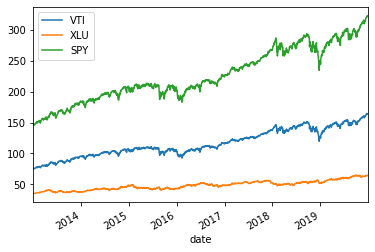

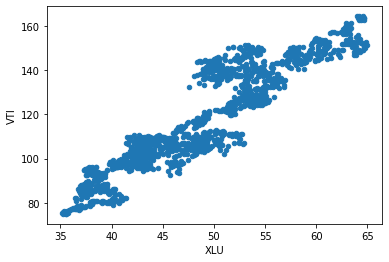

In [5]:
df.plot()
df.plot.scatter(x='XLU', y='VTI')

In [6]:
# Creating a training set from 2013-2015 for the OLS regression
dftrain = (df.copy()
            .truncate('2013-01-01', '2015-12-31'))

# determining OLS beta as a hedge ratio between XLU/VIT 
results=sm.ols(formula="VTI ~ XLU", data=dftrain[['XLU', 'VTI']]).fit()
print(results.params)
hedgeRatio=results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

Intercept   -13.067519
XLU           2.655167
dtype: float64
hedgeRatio=2.655167


In [7]:
# df will be the test set from 2016-2020
df = (df.copy()
      .truncate('2016-01-01', '2019-12-31'))
df.tail()

,VTI,XLU,SPY
date,,,
2019-12-24,163.440002,64.080002,321.230011
2019-12-26,164.229996,64.190002,322.940002
2019-12-27,164.080002,64.379997,322.859985
2019-12-30,163.190002,64.370003,321.079987
2019-12-31,163.619995,64.620003,321.859985


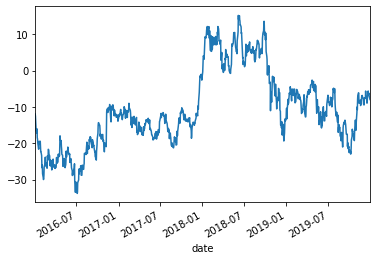

In [8]:
#Checking for stationarity in the differences in price series with the use of the hedgeratio
(df['VTI']-hedgeRatio*df['XLU']).plot()

the difference in VTI - XLU * HR  does not appear to be stationary, will perform Cointegrated Dickey Fuller test to evaluate further

In [9]:
# Cointegrated Dickey Fuller Test 

coint_t, pvalue, crit_value=ts.coint(df['XLU'], df['VTI'])
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print(crit_value)

t-statistic=-2.157681
pvalue=0.446282
[-3.90737061 -3.34221646 -3.04867279]


Results do not point to cointegration as T-stat isn't more negative than any of the critical Values. This is generally good since it shows that there is no cointegrating relationship between the two time series, therefore they can and do move in opposite directions of eachother, which implies they proxy for different risks.

In [10]:
# Calculating the Relative Strength of XLU/RSI which will be used as a signal
df['RSI']=df['XLU']/df['VTI']

#change in RSI to determine whether RSI is positive or negative over a period
df['deltaRSI']=df['RSI']-df['RSI'].shift()
df['deltaRSI'] = df['deltaRSI'].fillna(0)
df.head()

,VTI,XLU,SPY,RSI,deltaRSI
date,,,,,
2016-01-04,102.739998,43.189999,201.019196,0.420382,0.000000
2016-01-05,102.970001,43.500000,201.360001,0.422453,0.002072
2016-01-06,101.589996,43.419998,198.820007,0.427404,0.004951
2016-01-07,99.099998,43.130001,194.050003,0.435217,0.007813
2016-01-08,97.970001,43.110001,191.923004,0.440033,0.004816


In [11]:
#Creating a weekly sum of RSI delta, used as signal for entire next week
df['RSIsig'] = df['deltaRSI'].rolling(5).sum().shift()

df2 = (df.copy()
       .drop(df.index[0:5])
       .iloc[::5,:])
df2 = df2[['RSIsig']]
df2 = df2.rename(columns = {'RSIsig':'Signal'})
df = pd.merge(df,df2, how = 'left', on ='date')
df['Signal'] = df['Signal'].fillna(method='ffill')
df = df.drop(columns = ['deltaRSI','RSI','RSIsig'])
df.head(10)

,VTI,XLU,SPY,Signal
date,,,,
2016-01-04,102.739998,43.189999,201.019196,NaN
2016-01-05,102.970001,43.500000,201.360001,NaN
2016-01-06,101.589996,43.419998,198.820007,NaN
2016-01-07,99.099998,43.130001,194.050003,NaN
2016-01-08,97.970001,43.110001,191.923004,NaN
2016-01-11,97.910004,43.340000,192.110001,0.019651
2016-01-12,98.580002,43.169998,193.660797,0.019651
2016-01-13,96.040001,43.150002,188.830002,0.019651
2016-01-14,97.510002,43.799999,191.929993,0.019651


Since the algorithm is supposed to only enter into trades once a week, and hold for 5 days the signal must be the same for the entire period to avoid complications.

In [12]:
#Determining buy signals
#IF the RSI of the utilities to major market (VTI) is positive over a 5 day period, position into utilities, if negative position into the broader market
df['buyXLU']=(df['Signal']>0)*1
df['buyVTI']=(df['Signal']<0)*1

In [13]:
#determining PNL for XLU/VTI longs

df['XLUpnl_long']=(df['XLU']-df['XLU'].shift(1))*df['buyXLU']*np.floor(hedgeRatio)
df['VTIpnl_long']=(df['VTI']-df['VTI'].shift(1))*df['buyVTI']
df['pnl'] = df['XLUpnl_long']+df['VTIpnl_long']
df['cum_pnl'] = df['pnl'].cumsum()
VTIcpnl = (df['VTI']-df['VTI'].shift()).cumsum()
XLUcpnl = (df['XLU']-df['XLU'].shift()).cumsum()

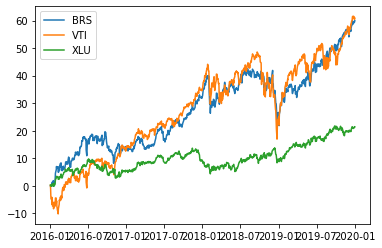

In [14]:
plt.plot(df['cum_pnl'], label = 'BRS')
plt.plot(VTIcpnl, label = 'VTI')
plt.plot(XLUcpnl, label = 'XLU')
plt.legend()

BRS APR=0.129344 BRS Sharpe=1.048314
VTI APR=0.123633 VTI Sharpe=0.961474
XLU APR=0.106198 XLY Sharpe=0.829416


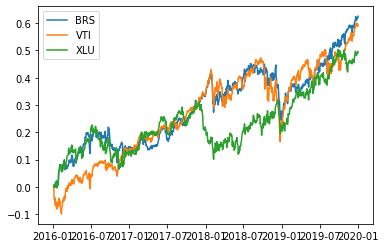

In [15]:
VTIret = (df['VTI']-df['VTI'].shift())/df['VTI'].shift()
XLUret = (df['XLU']-df['XLU'].shift())/df['XLU'].shift()
BRSret = VTIret*df['buyVTI']+XLUret*df['buyXLU']
BRScret = np.cumprod(1 + BRSret) -1
VTIcret = np.cumprod(1 + VTIret) -1
XLUcret = np.cumprod(1 + XLUret) -1
plt.plot(BRScret, label = 'BRS')
plt.plot(VTIcret, label = 'VTI')
plt.plot(XLUcret, label = 'XLU')
plt.legend()
print('BRS APR=%f BRS Sharpe=%f' % (np.prod(1+BRSret)**(252/len(BRSret))-1, np.sqrt(252)*np.mean(BRSret)/np.std(BRSret)))
print('VTI APR=%f VTI Sharpe=%f' % (np.prod(1+VTIret)**(252/len(VTIret))-1, np.sqrt(252)*np.mean(VTIret)/np.std(VTIret)))
print('XLU APR=%f XLY Sharpe=%f' % (np.prod(1+XLUret)**(252/len(XLUret))-1, np.sqrt(252)*np.mean(XLUret)/np.std(XLUret)))

Long only BRS algo generates slightly higher APR and Sharpe ratio than the individual ETFs 
Since these returns are long only algorithm, they are exposed to beta, therefore need to evaluate the short side using the same signal. When entering a long position in utilities (XLU) we short the broader general market (VTI)

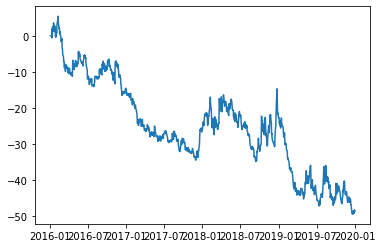

In [16]:
#just going to use the reverse signals, when utilities RSI is positive, long utilities/short the market, vice versa

#sell signals
df['sellXLU']=(df['Signal']<0)*1*np.floor(hedgeRatio)
df['sellVTI']=(df['Signal']>0)*1

df['XLUshort_pnl']=(df['XLU'].shift()-df['XLU'])*df['sellXLU']
df['VTIshort_pnl']=(df['VTI'].shift()-df['VTI'])*df['sellVTI']

df['short_pnl'] = df['XLUshort_pnl']+df['VTIshort_pnl']
df['short_cum_pnl'] = df['short_pnl'].cumsum()
plt.plot(df['short_cum_pnl'])

Results demonstrate that the signal does not perform well on the short side and implmenting it would erase almost the gains for the long only strategy. Therefore it is safe to assume that this strategy exhibits very little alpha throughout the last 4 years. 